# Evaluation of semantic similarity on LLM extraction

**Protocol**:
1. load extracted json
2. calculate embeddings
3. project on reduce dimension and estimate cluster
4. evaluate with naive approach the quality of the cluster
5. determine the topic of the cluster
    - with LLM iteration

In [2]:
import json
import pickle as pkl
import numpy as np
import gc
from pathlib import Path
from datasets import Dataset
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

In [3]:
RUN_PATH = Path("./run").resolve()
DATA_PATH = Path("../data/163/").resolve()
MODEL_NAME = "dangvantuan/sentence-camembert-large"
SAVE_PATH = Path("../data/embeddings").resolve()

In [4]:
STS_MODEL = SentenceTransformer(MODEL_NAME)
STS_MODEL.max_seq_length = 512

No sentence-transformers model found with name /home/machine_learning/.cache/torch/sentence_transformers/dangvantuan_sentence-camembert-large. Creating a new one with MEAN pooling.


In [5]:
with open(RUN_PATH / "llm_analysis.pkl", "rb") as file:
    run_data = pkl.load(file)

## Embedding calculation of extracted LLM content

In [5]:
extracted_content = []
index = []
for r in tqdm(run_data):
    if r.get("main_content", False):
        items = r["main_content"]
        extracted_content.extend(items)
        index.extend([r["id"]] * len(items))

dataset = Dataset.from_list(
    [{"id": idx_, "text": content} for idx_, content in zip(index, extracted_content)]
)
dataset

100%|██████████| 52301/52301 [00:00<00:00, 2045602.24it/s]


Dataset({
    features: ['id', 'text'],
    num_rows: 169133
})

In [ ]:
# embeddings = []
# for content in tqdm(extracted_content):
#     emb_ = sts_model.encode(content)
#     embeddings.append(emb_)

In [8]:
dataset = dataset.map(
    lambda x: {"embeddings": STS_MODEL.encode(x)},
    input_columns="text",
    num_proc=1,
    batch_size=1024,
)

Map:   0%|          | 0/169133 [00:00<?, ? examples/s]

In [10]:
dataset.save_to_disk(SAVE_PATH)

Saving the dataset (0/2 shards):   0%|          | 0/169133 [00:00<?, ? examples/s]

## Cluster evaluation

In [71]:
dataset = Dataset.load_from_disk(str(SAVE_PATH) + "_2")

/home/machine_learning/.anaconda3/envs/ia4gov/lib/python3.11/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [109]:
x = [i for i in dataset['cluster'] if i is not None]
cls_index = np.unique(x)

In [96]:
from pprint import pprint

In [118]:
test = STS_MODEL.encode("supprimer les niches fiscales")

In [121]:
subdataset = dataset.filter(lambda t: t == "supprimer les niches fiscales", input_columns='text')

Filter:   0%|          | 0/169133 [00:00<?, ? examples/s]

In [127]:
subdataset

Dataset({
    features: ['id', 'text', 'embeddings', 'umap', 'umap_2d', 'cluster'],
    num_rows: 1910
})

In [140]:
from umap import UMAP
from pacmap import PaCMAP

In [141]:
umap = PaCMAP(random_state=42)
umap.fit(subdataset[0:100]["embeddings"])

/home/machine_learning/.anaconda3/envs/ia4gov/lib/python3.11/site-packages/pacmap/pacmap.py:819: UserWarning: Warning: random state is set to 42
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')
/home/machine_learning/.anaconda3/envs/ia4gov/lib/python3.11/site-packages/sklearn/decomposition/_truncated_svd.py:273: RuntimeWarning: divide by zero encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
/home/machine_learning/.anaconda3/envs/ia4gov/lib/python3.11/site-packages/sklearn/decomposition/_truncated_svd.py:273: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var


PaCMAP(pair_FP=array([[ 0, 51],
       [ 0, 64],
       [ 0, 45],
       ...,
       [99, 38],
       [99, 52],
       [99, 87]], dtype=int32),
       pair_MN=array([[ 0, 71],
       [ 0, 64],
       [ 0, 96],
       [ 0,  3],
       [ 0, 61],
       [ 1,  6],
       [ 1, 68],
       [ 1, 69],
       [ 1,  4],
       [ 1, 69],
       [ 2, 13],
       [ 2, 63],
       [ 2,  2],
       [ 2, 72],
       [ 2, 64],
       [ 3,  5],
       [ 3, 35],
       [ 3, 79],
       [ 3, 65],
       [ 3, 34],
       [ 4, 11],
       [ 4, 44],
       [ 4, 54],
       [ 4, 63],
       [ 4, 79],
       [ 5, 74],
       [ 5, 63],
       [ 5, 73],
       [ 5,  0],
       [ 5, 55],
       [ 6, 69],
       [ 6,  8],
       [ 6, 73],
       [ 6, 64],
       [ 6,  0],
       [ 7, 87],
       [ 7, 54]...
       [94, 34],
       [94, 93],
       [94, 18],
       [94, 26],
       [94, 77],
       [95, 89],
       [95, 87],
       [95, 81],
       [95, 84],
       [95, 16],
       [96, 74],
       [96, 39],
       [96, 53],
       [96, 10],
       [96, 33],
       [97, 42],
       [97, 48],
       [97, 53],
       [97, 46],
       [97, 32],
       [98, 10],
       [98, 10],
       [98, 64],
       [98, 51],
       [98, 34],
       [99, 38],
       [99, 53],
       [99,  6],
       [99, 40],
       [99,  6]], dtype=int32),
       pair_neighbors=array([[ 0, 79],
       [ 0, 77],
       [ 0, 76],
       ...,
       [99, 59],
       [99, 58],
       [99, 56]], dtype=int32),
       random_state=42)

In [143]:
test = umap.transform(
    subdataset[0:100]["embeddings"], basis=subdataset[0:100]["embeddings"]
)

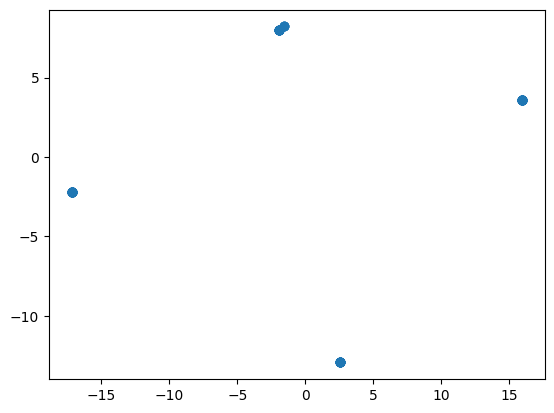

In [144]:
plt.scatter(*test.T)

In [129]:
a = subdataset[10]["umap_2d"]
b = subdataset[60]["umap_2d"]

a == b

False

In [119]:
test

array([-0.6878276 , -0.17038675,  0.3779374 , ..., -0.21773651,
       -0.14337079,  0.46836394], dtype=float32)

In [110]:
for i in cls_index:
    subdata = dataset.filter(lambda cat: np.isin(cat, i), input_columns="cluster")
    #########""
    print("Size cluster:", len(subdata))
    pprint(subdata[:10]["text"])
    print("\n")

Filter:   0%|          | 0/169133 [00:00<?, ? examples/s]

Size cluster: 8022
['faire payer les plus riches avant de taper sur les classes moyennes',
 "remettre l'ISF",
 'faire payer les entreprises du cac40',
 'baisser les impôts des plus vulnérables et des classes moyennes',
 'supprimer les niches fiscales',
 "réviser les tranches d'imposition et les taux",
 'supprimer la TVA sur les produits de 1ère nécessité',
 'appliquer une TVA plus basse',
 'sur les produits de première nécessité',
 "sur l'ensemble des produits taxés"]




Filter:   0%|          | 0/169133 [00:00<?, ? examples/s]

Size cluster: 405
["augmenter le nombre de tranches de l'IR",
 'resserrer les tranches 1 à 3',
 'passer la tranche 4 à 50%',
 'créer une tranche intermédiaire à 60%',
 'taxer à 70% les revenus supérieurs à 300000',
 'supprimer les niches fiscales',
 "lutte efficace contre l'évasion fiscale",
 'obligation pour les entreprises étrangères de payer des impôts en France',
 'imposer les revenus pour tous',
 "révision à la baisse des tranches d'imposition"]




Filter:   0%|          | 0/169133 [00:00<?, ? examples/s]

Size cluster: 892
["faire payer l'IR des le premier euro",
 'ajouter une tranche à 50% sur les très hauts revenus',
 'baisser légèrement les taux sur les classes moyennes',
 'réduire/supprimer/plafonner les niches fiscales',
 "ne pas revenir sur l'ISF",
 "rebaptiser l'IFI en ISFi",
 'baisse TVA sur les produits de première nécessité',
 'augmenter TVA sur les produits luxe',
 'baisse TVA sur les énergies vertes',
 'suppression/réduction des impôts de production']




Filter:   0%|          | 0/169133 [00:00<?, ? examples/s]

Size cluster: 948
['baisse des indemnités pour chaque élu',
 'imposition plus importante des grandes sociétés et multinationales',
 "taxes bien plus élevées sur l'Import",
 'refonte des niches de défiscalisation',
 'pénalités et taxes trésimportantes pour les entreprises qui délocalisent',
 'contribution globale des ménages',
 'progressivité avec les revenus',
 'remise à plat des tranches',
 'arrêt de certaines niches fiscales',
 "création d'une tranche IR à 50 ou 55%"]




Filter:   0%|          | 0/169133 [00:00<?, ? examples/s]

Size cluster: 700
['supprimer les impôts et taxes incompréhensibles',
 "supprimer l'imposition de la part CSG imposable sur des revenus déjà déduits "
 "du net pour l'ensemble des revenus",
 "fusionner la CSG et l'impôt sur le revenu",
 'instaurer des tranches sur ce nouvel impôt',
 'tranche maximale à 60%',
 'diminution des niches fiscales',
 'faire payer une juste quotes-parts à tous les salariés et professionnels '
 'libéraux',
 "arrêter l'impôt sur le revenu et utiliser la CSG pour tous",
 'supprimer un impôt qui touche tous le monde',
 'TVA']




Filter:   0%|          | 0/169133 [00:00<?, ? examples/s]

Size cluster: 577
['supprimer toutes les niches fiscales',
 'taxer beaucoup plus les successions, par paliers progressifs',
 'taxer les successions à 50/70%',
 "augmenter la base d'imposition",
 'ajouter des tranches',
 'tranche minimale plus basse',
 'tranche marginale à 55%',
 "hausser le taux de l'impôt sur les grosses successions",
 'augmenter le nombre de tranches',
 'taxer plus fortement les grosses successions']




Filter:   0%|          | 0/169133 [00:00<?, ? examples/s]

Size cluster: 1694
['supprimer les niches fiscales',
 'empêcher l’évasion fiscale',
 'ajouter des tranches fiscales au delà de 45%',
 'protéger les classes inférieures et moyennes',
 "lutter contre l'évasion et l'optimisation fiscales",
 "lutter contre l'évasion fiscale et la fraude",
 'évaluer les niches fiscales',
 'supprimer les niches abusives',
 'créer une tranche supplémentaire',
 'taxer les multinationales']




Filter:   0%|          | 0/169133 [00:00<?, ? examples/s]

Size cluster: 394
['imposition sur les revenus pour tous dès le 1er euro',
 "création d'une tranche inférieure imposée à 5 %",
 "création d'une tranche supérieure imposée à 50 % pour les revenus supérieurs "
 'à 1 M euros',
 'Impôt sur le revenu pour tous dès le 1er euro',
 'tranche basse',
 'suppression de la tranche à 5%',
 'imposer tous',
 'impôt symbolique pour les plus modestes',
 "taxe d'habitation pour tous",
 "prendre en compte l'ensemble des revenus"]




Filter:   0%|          | 0/169133 [00:00<?, ? examples/s]

Size cluster: 3000
['adapter la TVA en fonction des catégories de produits',
 "Très Faible TVA sur la nourriture issu de l'agriculture francaise, sur les "
 'produits de première necessité',
 'Faible sur les produits made in france',
 'TVA classique sur le reste',
 'supprimer certaines niches fiscales',
 'créer une tranche supérieure à 50%',
 'diminuer la TVA sur les produits de première nécessité',
 'augmenter la TVA sur les produits de luxe',
 'suppression des niches fiscales',
 "suppression d'aides inutiles"]




Filter:   0%|          | 0/169133 [00:00<?, ? examples/s]

Size cluster: 638
["développer la lutte contre l'évasion et la fraude fiscales",
 "revoir les tranches du barème de l'impôt sur le revenu",
 'supprimer les niches fiscales',
 'impôts pour tous dès le premier euro',
 'davantage de tranches fiscales',
 'réexamen des niches fiscales',
 'fin de la hausse de CSG pour les retraités',
 'réduire considérablement la TVA',
 'supprimer la TVA sur les produits de 1ère nécessité',
 "créer des tranches supplémentaires d'impôt sur le revenu"]




Filter:   0%|          | 0/169133 [00:00<?, ? examples/s]

Size cluster: 23922
['arrêter de préférer les classes moyennes à la dépense des riches et des '
 'bénéficiaires du système',
 'impôts sur le revenu pour tout le monde',
 'baisse de la tva pour tous les produits de 1ère nécessité et de sécurité',
 "plus de progressivité pour l'impôt sur les revenus",
 'diminuer la contribution des classes moyennes',
 'étaler les taux de 0 à 90% sur 14 tranches',
 "une progressivité plus fine de l'impôt sur le revenu",
 '12 tranches',
 'taux maximal à 54%',
 'impôts et allocations progressifs ou dégressifs sans seuils']




Filter:   0%|          | 0/169133 [00:00<?, ? examples/s]

Size cluster: 879
["recalculer le bareme de l'impôt",
 'redéfinir les tranches',
 'moins taxer les classes moyennes',
 "élargir l'assiette fiscale",
 "atteindre à au moins 75% des ménages payant l'impôt",
 "adapter les tranches d'impositions",
 'égaliser les tranches intermédiaires',
 "maintenir la suppression de l'ISF",
 'un seul impôt direct',
 'individuel et progressif']


